<a href="https://colab.research.google.com/github/DeKUT-DSAIL/miti360/blob/main/notebooks/tracking_crown_growth.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab">
</a>

### Extracting Tree Crown Embeddings using SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt.

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

We shall use the bounding box annotations in [annotations](../sample_data/annotations) as our box prompts to SAM to predict the mask representing each tree crown. Since our images are georeferenced, we can find the size of each tree crown in $m^2$ by converting from pixel space to real world measurements using the spatial sampling distance (SSD). In our case, this SSD is 2 cm i.e., each pixel is 2 cm $\times$ 2 cm in the real world.

For Google Colab, uncomment and run the following two cells.
Subsequently, you will need to change all local paths to begin with `/content/miti360/...`

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !git clone https://github.com/DeKUT-DSAIL/miti360.git

In [1]:
using_colab = False # change this for Colab

if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir Images
    !wget -P Images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P Images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

else:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.6.0+cu126
Torchvision version: 0.21.0+cu126
CUDA is available: True


In [62]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from scipy.ndimage import label

from tqdm import tqdm
from glob import glob
import matplotlib.patches as mpatches

from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.decomposition import PCA

from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

We'll define some helper functions

In [6]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


### Configuring SAM

In [ ]:
# local: "D:\learning\SAM\models\sam_vit_h_4b8939.pth"
# colab: "/content/sam_vit_h_4b8939.pth"
sam_checkpoint = "D:\learning\SAM\models\sam_vit_h_4b8939.pth" # change this path for colab
model_type = "vit_h"

device = "cuda"

In [4]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

In [5]:
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [35]:
def extract_bboxes_from_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    bboxes = []
    for obj in root.findall("object"):
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)
        bboxes.append([xmin, ymin, xmax, ymax])
    
    return bboxes

In [40]:
def predict_masks_from_bboxes(predictor, bboxes):
    masks = []
    for bbox in tqdm(bboxes, total=len(bboxes)):
        box = np.array(bbox)
        mask, _, _ = predictor.predict(box=box, multimask_output=False)
        masks.append(mask[0])
        # print(f"Area: {mask.sum() * 81 / 10000:.2f} m²")

    merged_mask = np.logical_or.reduce(masks)
    return merged_mask

In [ ]:
filename_substr = "2024_08_1" # change this to process different images/annotations
img_path = f'../sample_data/images/{filename_substr}.png'
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [48]:
predictor = SamPredictor(sam)
predictor.set_image(image)

100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


True

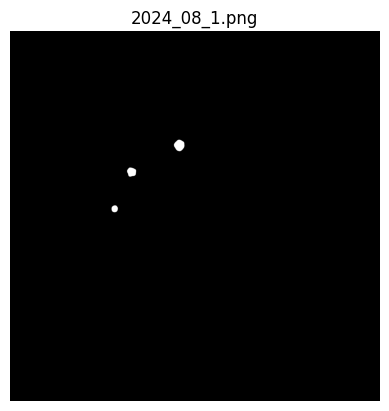

In [61]:
xml_file = f"../sample_data/annotations/{filename_substr}.xml"
bboxes = extract_bboxes_from_xml(xml_file)

merged_mask = predict_masks_from_bboxes(predictor, bboxes)#.astype(np.uint8) * 255
# merged_mask = cv2.cvtColor(merged_mask, cv2.COLOR_GRAY2RGB)
# mask = cv2.inRange(merged_mask, (0, 0, 0), (0, 0, 0))
# merged_mask[mask != 0] = (200, 200, 200)

plt.imshow(merged_mask, cmap='gray')
plt.axis('off')
plt.title(f"{filename_substr}.png")

mask_path = f'../sample_data/masks/{filename_substr}_mask.png'
cv2.imwrite(mask_path, merged_mask.astype(np.uint8) * 255)

Text(0.5, 1.0, 'February 2025')

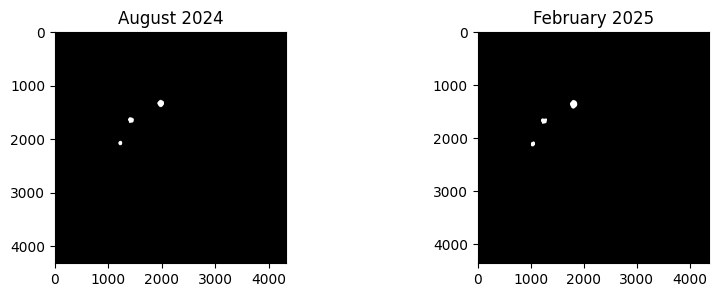

In [55]:
# mask_1 = cv2.imread('../sample_data/masks/2023_03_1.png', cv2.IMREAD_GRAYSCALE)
mask_2 = cv2.imread('../sample_data/masks/2024_08_1_mask.png', cv2.IMREAD_GRAYSCALE)
mask_3 = cv2.imread('../sample_data/masks/2025_02_1_mask.png', cv2.IMREAD_GRAYSCALE)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
# axes[0].imshow(mask_1, cmap='gray')
# axes[0].set_title('March 2023')
axes[0].imshow(mask_2, cmap='gray')
axes[0].set_title('August 2024')
axes[1].imshow(mask_3, cmap='gray')
axes[1].set_title('February 2025')


Let's use different colours for each tree crown for easier visual tracking.

In [63]:
def save_coloured_masks(substrs):
    for substr in substrs:
        mask = cv2.imread(f'../sample_data/masks/{substr}_mask.png', cv2.IMREAD_GRAYSCALE)

        # Find connected components (patches)
        labeled_mask, num_features = label(mask > 0)

        # Calculate area for each patch and sort by size (descending)
        patch_areas = [(i, (labeled_mask == i).sum()) for i in range(1, num_features + 1)]
        patch_areas.sort(key=lambda x: -x[1])  # Sort by area descending

        # Assign colors: red, green, blue
        colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0)]  # BGR for OpenCV

        # Create a color image
        color_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)

        for idx, (patch_idx, _) in enumerate(patch_areas):
            color = colors[idx % 3]
            color_mask[labeled_mask == patch_idx] = color

        cv2.imwrite(f'../sample_data/masks/{substr}_colored.png', color_mask)
    
    print("Coloured masks saved.")

In [66]:
masks_substr = ['2024_08_1', '2025_02_1']
save_coloured_masks(masks_substr)

Coloured masks saved.


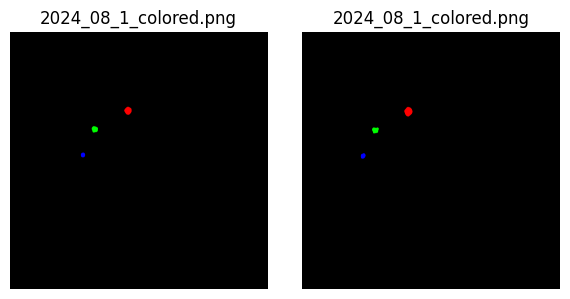

In [71]:
# update these paths to your images
img1_path = f'../sample_data/masks/{masks_substr[0]}_colored.png'
img2_path = f'../sample_data/masks/{masks_substr[1]}_colored.png'

# read color images with cv2 (BGR)
img1 = cv2.imread(img1_path, cv2.IMREAD_COLOR)
img2 = cv2.imread(img2_path, cv2.IMREAD_COLOR)

# convert to RGB for matplotlib
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) if img1 is not None else None
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) if img2 is not None else None

fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].imshow(img1_rgb)
axes[0].axis('off')
axes[0].set_title(f'{masks_substr[0]}_colored.png')

axes[1].imshow(img2_rgb)
axes[1].axis('off')
axes[1].set_title(f'{masks_substr[0]}_colored.png')

plt.tight_layout()
plt.show()

Now let's overlay these coloured masks over the original images for visualisation.

In [86]:
def overlay_colored_mask(image, mask, alpha=0.5, mask_bgr=False):
    """
    Overlay a coloured mask (patches on black background) on a colour image using OpenCV.
    Args:
        image: HxWx3 uint8 colour image (RGB or BGR)
        mask:  HxWx3 uint8 coloured mask (patches coloured, background black) OR HxW binary mask
        alpha: blend weight for the mask (0..1)
        mask_bgr: if True, convert mask from BGR -> RGB to match an RGB `image` (set to True when mask was loaded with cv2.imread)
    Returns:
        overlay: HxWx3 uint8 image with mask blended where mask != black
    """
    # if mask is single-channel binary, convert to 3-channel coloured mask (green patches)
    if mask.ndim == 2:
        colored_mask = np.zeros_like(image)
        colored_mask[mask > 0] = (0, 255, 0)  # green in RGB/BGR (same position)
    else:
        colored_mask = mask.copy()

    # if mask was read with cv2.imread and image is RGB, convert mask to RGB
    if mask_bgr:
        colored_mask = cv2.cvtColor(colored_mask, cv2.COLOR_BGR2RGB)

    # resize mask if needed
    if colored_mask.shape[:2] != image.shape[:2]:
        colored_mask = cv2.resize(colored_mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    # detect non-black pixels in mask
    mask_nonzero = np.any(colored_mask != 0, axis=2)

    # if nothing to overlay, return a copy of the original
    if not mask_nonzero.any():
        return image.copy()

    # build a masked-coloured image (only coloured pixels kept)
    masked_coloured = np.zeros_like(image)
    masked_coloured[mask_nonzero] = colored_mask[mask_nonzero]

    # blend full images and then use only mask areas from blended result
    blended = cv2.addWeighted(masked_coloured, float(alpha), image, float(1 - alpha), 0)
    overlay = image.copy()
    overlay[mask_nonzero] = blended[mask_nonzero]

    return overlay

Save the overlayed images

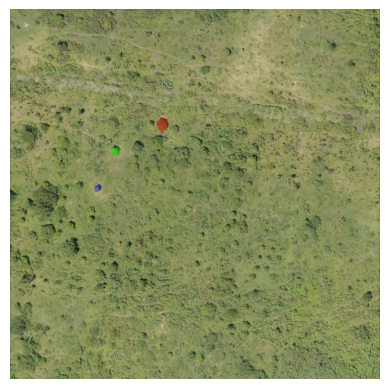

In [ ]:
image = cv2.imread('../sample_data/images/2025_02_1.png', cv2.IMREAD_COLOR_RGB)
overlayed = overlay_colored_mask(image, mask_3, alpha=0.4, mask_bgr=True)
cv2.imwrite('../sample_data/overlays/2025_02_1_overlay.png', cv2.cvtColor(overlayed, cv2.COLOR_RGB2BGR))
plt.imshow(overlayed); plt.axis('off'); plt.show()

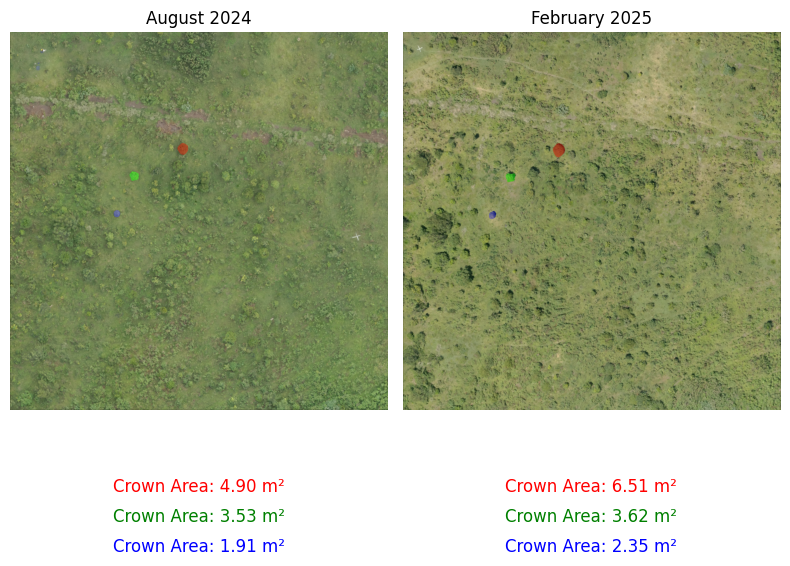

In [92]:
overlay1 = cv2.imread('../sample_data/overlays/2024_08_1_overlay.png', cv2.IMREAD_COLOR_RGB)
overlay2 = cv2.imread('../sample_data/overlays/2025_02_1_overlay.png', cv2.IMREAD_COLOR_RGB)

mask_1 = cv2.imread('../sample_data/masks//2024_08_1_colored.png')
mask_2 = cv2.imread('../sample_data/masks//2025_02_1_colored.png')

masks = [mask_1, mask_2]
overlays = [overlay1, overlay2]
titles = ['August 2024', 'February 2025']
patch_colors = ['red', 'green', 'blue']
convs = [4, 4] # Each pixel represents an area of 2 cm x 2 cm i.e., spatial sampling distance of 2 cm

fig, axes = plt.subplots(1, 2, figsize=(8, 5))

for mask, overlay, ax, title in zip(masks, overlays, axes, titles):

    ax.imshow(overlay, cmap='gray')
    ax.set_title(title)
    ax.axis('off')
    
    # Find connected components (patches)
    labeled_mask, num_features = label(mask > 0)
    areas = [(labeled_mask == j).sum() for j in range(1, num_features + 1)]
    
    # Annotate each patch area below the image, with the specified color sequence
    for j, area in enumerate(areas):
        color = patch_colors[j % len(patch_colors)]
        ax.text(
            0.5, -0.18 - 0.08 * j,  # stack texts vertically
            f'Crown Area: {area * convs[titles.index(title)] / 10000:.2f} m²',
            transform=ax.transAxes,
            fontsize=12,
            va='top', ha='center',
            color=color,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
        )

plt.tight_layout()
plt.savefig('crown_areas.png', bbox_inches='tight', dpi=900)
plt.show()

We can see clearly that the tree crowns have increased in size between August and February.